In [ ]:
import pandas as pd
import numpy as np
import nltk 

import joblib

# Load Data Viz Pkgs
import seaborn as sns

# Load Text Cleaning Pkgs
# import neattext.functions as nfx

# Loading ML pkgs
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# Data Transformers and models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, f1_score
from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Plotting
import matplotlib.pyplot as plt

# Stemming and Cleaning helpers
import spacy
from neattext.functions import remove_punctuations, remove_userhandles, remove_stopwords, remove_special_characters, remove_numbers

spacy.prefer_gpu()

False

### Data Loading

This section of the notebook is dedicated to the exploration and visualization of the emotion datasets.
We will be loading multiple datasets that contain text and their corresponding emotional labels. 

We chose to use the first two datasets as the main datasets, as they have similar labels and can be used to augment one another. 

The NRC dataset will be used for feature engineering later on.
The datasets include:

1. **ISEAR Dataset**: This dataset includes phrases that are categorized by different emotions. *(We're using a slightly modified version of the ISEAR dataset, which has identical data just stored slightly differntly to make loading easier.)*
    - link: https://huggingface.co/datasets/TahaRasouli/ISEAR
2. **Text Emotions Dataset**: Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise.
    - link: https://huggingface.co/datasets/dair-ai/emotion
3. **NRC Emotion Lexicon**: This dataset consists of individual words that are linked to specific emotions. Some words appear multiple times, as they can denote more than one emotion.
    - link: https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

After loading the datasets, we will perform the following operations:
- **Renaming Columns**: We will ensure that the columns are consistently named across datasets for easier merging.
- **Concatenating Datasets**: We will combine all the datasets into a single DataFrame for comprehensive analysis.
- **Sampling Data**: A random sample of the combined dataset will be displayed to give an overview of the data structure and content.

As we are concerned with detecting the emotion of **Phrases**, and not individual words, we will be excluding the NRC dataset from our test-split. We're doing this because we are not interested in classifiying individual words, and some of the words actually have multiple classes. Instead, the NRC dataset will be used for feature engineering(as we will see later on).

In [2]:
# Paths for the datasets
ISEAR_PATH = "./data/input/ISEAR_modified.csv"
EMOT_PATH = "./data/input/text_emotions.csv"
NRC_PATH = "./data/input/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"

In [3]:
# read the isear dataset
isear_df = pd.read_csv(ISEAR_PATH)

# read the emotions dataset
emot_df = pd.read_csv(EMOT_PATH)

In [4]:
print("ISEAR Shape: ", isear_df.shape)
isear_df.sample(5)

ISEAR Shape:  (7652, 2)


,Emotion,Text
959,anger,When stupid people push me during rush time in...
7295,guilt,"I cut a friend's hair in anger, without any co..."
2828,shame,I lied to my best friend and I wouldn't reform...
3039,disgust,I felt it today when the bus driver shouted ra...
1672,shame,Some time ago we had a tournament in our tenni...


In [5]:
print(" Shape: ", emot_df.shape)
emot_df.sample(5)

 Shape:  (20000, 2)


,Text,Emotion
8238,i am on the write track i feel contented and a...,joy
11360,i guess i should feel appreciative of that,joy
19027,i hate this feeling of helpless,sadness
13514,i feel pleasantly mellow regardless,joy
17313,i honestly wish christmas was celebrated in th...,joy


## Construct the dataset

In [6]:
df = pd.concat([isear_df, emot_df], ignore_index=True)
df.sample(10)

,Emotion,Text
11976,anger,i feel is hostile kinship or mounting nausea d...
16680,joy,i feel very privileged to know each and every ...
18807,sadness,i feel as if im a doomed to fail b setting mys...
13151,joy,i still have such a hard time writing my work ...
19750,sadness,i now feel that food is to be enjoyed and not ...
12506,anger,i feel petty things but not to the extent that...
11019,joy,i came to the place on base because i wasnt fe...
26252,sadness,i learnt that expectations of people are not a...
9911,fear,i feel poisoned and tortured by this room
5089,guilt,"When I had lied, saying that I never take brea..."


In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    df["Text"], df["Emotion"], test_size=0.2, random_state=42
)

## Data Visualization

In [8]:
# Value Counts
df['Emotion'].value_counts()

Emotion
joy         7853
sadness     6891
anger       3803
fear        3466
love        1641
disgust     1094
shame       1094
guilt       1091
surprise     719
Name: count, dtype: int64

<Axes: xlabel='Emotion', ylabel='count'>

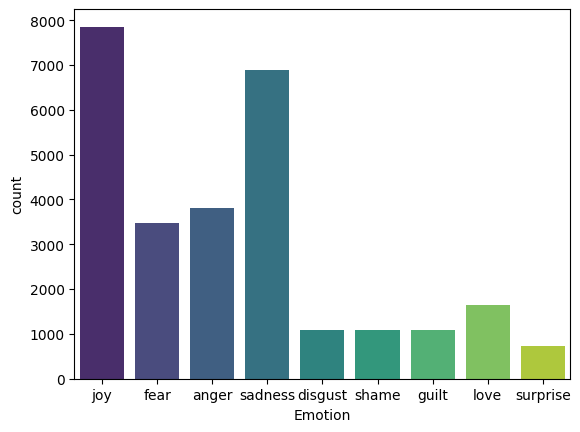

In [9]:
# Plot
sns.countplot(x='Emotion',data=df, palette='viridis', hue='Emotion')

## Model Pipeline

## Setting up Feature Engineering

**Role of the NRC Lexicon**
- Feature Engineering:
Instead of directly adding NRC entries to the training data (which risks overfitting to single-word examples), we use it to enrich the model’s understanding of emotion-related words. In other words,
make it form associations with word frequencies to emotions.

    - For a given text, we count how many words are associated with each emotion (e.g., "happy" contributes to "joy," "cry" to "sadness").

    - These counts become additional numerical features fed to the model alongside TF-IDF vectors.

    **Why This Works:**

    - The model learns to recognize patterns where certain emotion-word frequencies correlate with specific labels (e.g., high "joy" word counts → "joy" prediction).

### Load the NRC Lexicon for feature detection

In [10]:
# read the NRC dataset
nrc_df = pd.read_csv(
    NRC_PATH, sep="\t", header=None, names=["word", "emotion", "association"]
)

# Loading the lexicon, ignoring positive/negative emotion tags (this ain't for sentiment analysis)
# And no longer need the association col since we picked the ones that have association==1
nrc_lexicon = nrc_df[
    (nrc_df["association"] == 1) & (~nrc_df["emotion"].isin(["positive", "negative"]))
].drop(columns=["association"])


In [11]:
nrc_lexicon.sample(10)

,word,emotion
26269,consort,trust
118251,spirits,anticipation
91959,pertinent,trust
56242,grime,disgust
129083,tragedy,fear
47954,feat,joy
58030,harshness,anger
23179,colonel,trust
91367,peril,sadness
105199,reporter,trust


In [30]:
import itertools

# Creating a dictionary mapping words to their associated emotions
nrc_emotion_map = nrc_lexicon.groupby("word")["emotion"].apply(list).to_dict()

nrc_emotion_categories = nrc_lexicon["emotion"].unique()

print("Emotion Categories: ", nrc_emotion_categories)

# Display a sample from the emotion map
sample_df = pd.DataFrame(list(itertools.islice(nrc_emotion_map.items(), 10)), columns=["Word", "Emotions"])
sample_df


Emotion Categories:  ['trust' 'fear' 'sadness' 'anger' 'surprise' 'disgust' 'joy'
 'anticipation']


,Word,Emotions
0,abacus,[trust]
1,abandon,"[fear, sadness]"
2,abandoned,"[anger, fear, sadness]"
3,abandonment,"[anger, fear, sadness, surprise]"
4,abbot,[trust]
5,abduction,"[fear, sadness, surprise]"
6,aberration,[disgust]
7,abhor,"[anger, disgust, fear]"
8,abhorrent,"[anger, disgust, fear]"
9,abject,[disgust]


In [13]:
class EmotionFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, emotion_map, emotion_categories):
        self.emotion_map = emotion_map
        self.emotion_categories = emotion_categories

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for text in X:
            words = text.split()
            emotion_counts = {emotion: 0 for emotion in self.emotion_categories}
            for word in words:
                if word in self.emotion_map:
                    for emotion in self.emotion_map[word]:
                        emotion_counts[emotion] += 1
            # Normalize by text length
            text_length = len(words) if len(words) > 0 else 1
            normalized_counts = [
                emotion_counts[emotion] / text_length
                for emotion in self.emotion_categories
            ]
            features.append(normalized_counts)
        return np.array(features)

## Data Cleaning

This section of the notebook is dedicated to the data cleaning process. 
Data cleaning is a crucial step in preparing the dataset for analysis and modeling. 
In this part, we will perform several operations to ensure that the text data is in a suitable format for further processing. 
The operations include:

1. **Removing Punctuations**: Punctuations can interfere with text analysis, so we will remove them from the text.
2. **Removing User Handles**: Since datasets like these tend to originate from social media, user handles *(e.g., @username)* will be removed to avoid bias in the analysis.
3. **Removing Stopwords**: Common words that do not contribute to the meaning of the text *(e.g., "and", "the")* will be eliminated.
4. **Removing Digits**: Any numerical values will be removed as they may not be relevant to the emotional content of the text.
6. **Stemming**: Words will be reduced to their root form to ensure that different forms of a word are treated as the same *(e.g., "running" becomes "run")*.

After these cleaning steps, we will have a more uniform and relevant dataset that is ready for emotion detection analysis.


### Stemming & Lemmatization

Stemming is a text normalization technique that reduces words to their root form. This process involves reducing complex words into their root morphemes.

This process helps in treating different forms of a word as the same, which is particularly useful in text analysis. 
For example, words like "running", "ran", and "runner" would all be reduced to the root word "run". 
By applying stemming, we can improve the efficiency of our emotion detection model by reducing the dimensionality of the text data, 
allowing it to focus on the core meaning of the words rather than their variations.

In [14]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def clean_text(x: list):
    def preprocess(text: str):
        # Step 1: Basic cleaning
        text = remove_punctuations(text)
        text = remove_userhandles(text)
        text = remove_stopwords(text)
        text = remove_special_characters(text)
        text = remove_numbers(text)
        
        # Step 2: POS-based lemmatization
        doc = nlp(text)
        filtered_tokens = [
            token.lemma_.lower()
            for token in doc
            if token.pos_ in ["ADJ", "VERB", "ADV", "NOUN"]  # Focus on emotion-rich POS tags
        ]
        return " ".join(filtered_tokens)

    return [preprocess(text) for text in x]
    


In [15]:
# Load spaCy model
# ps = PorterStemmer()
nlp = spacy.load("en_core_web_sm")

def clean_text(x: list):
    def preprocess(text: str):
        # Step 1: Basic cleaning
        text = remove_punctuations(text)
        text = remove_userhandles(text)
        # text = remove_stopwords(text)
        text = remove_special_characters(text)
        text = remove_numbers(text)
        
        # Step 2: POS-based lemmatization
        doc = nlp(text)
        processed_tokens = []
        for token in doc:
            # stemmed_word = ps.stem(token.text.strip())
            stemmed_word = token.lemma_.lower()
            pos_tag = token.pos_
            if pos_tag in ["ADJ", "VERB", "ADV", "NOUN"]:
                processed_tokens.append(f"{stemmed_word}/{pos_tag}")
        return " ".join(processed_tokens)

    return [preprocess(text) for text in x]

# Define the preprocessing step
preprocessor = FunctionTransformer(clean_text)

In [16]:
# Testing the preprocessor function

# Create a DataFrame to compare original and cleaned text
comparison_df = pd.DataFrame({
    "Original Text": x_train[:10],
    "Cleaned Text": clean_text(x_train[:10])
})

comparison_df

,Original Text,Cleaned Text
6902,A boy in my class talking too loud in the lect...,boy/NOUN class/NOUN talk/VERB too/ADV loud/ADJ...
27271,i sat in the car and read my book which suited...,sit/VERB car/NOUN read/VERB book/NOUN suit/VER...
7395,When I was studying in the library - preparing...,study/VERB library/NOUN prepare/VERB test/NOUN...
18433,i feel cute and sexy all at once and its not s...,feel/VERB cute/ADJ sexy/ADJ all/ADV once/ADV s...
701,A drunken friend of mine was beating up anothe...,drunken/ADJ friend/NOUN mine/NOUN beat/VERB fr...
13060,id recommend using it before washing with a sh...,d/NOUN recommend/VERB use/VERB wash/VERB showe...
21059,i can remember feeling really amazed at how i ...,remember/VERB feel/VERB really/ADV amazed/ADJ ...
13238,i feel better about myself almost tasting my s...,feel/VERB well/ADJ almost/ADV taste/VERB succe...
7175,Being told that I am a stupid person.,tell/VERB stupid/ADJ person/NOUN
10862,i changed i feel that im taking advantage of h...,change/VERB feel/VERB take/VERB advantage/NOUN...


## Building the Model Pipeline

In [25]:

# Build the full pipeline
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("features", FeatureUnion([
        ("tfidf", TfidfVectorizer(
            ngram_range=(1, 4),  # Ngrams to capture phrases like "very happy" or "not happy"
            min_df=2,            # Ignore rare terms
        )),
        ("emotion", EmotionFeatureExtractor(
            emotion_map=nrc_emotion_map,
            emotion_categories=nrc_emotion_categories
        )),
    ])),
    # ('clf',LogisticRegression(
    #     penalty='l2', 
    #     C=1.0, 
    #     max_iter=500, 
    #     random_state=42, 
    #     class_weight='balanced',
    # )),
    # ("clf", SVC(
    #     kernel="linear",
    #     C=1.0,
    #     class_weight="balanced",
    #     probability=True,
    #     random_state=42,
    #     verbose=True,
    # )),
    
    ("clf", CalibratedClassifierCV(
        estimator=LinearSVC(
            C=1.0,
            # dual=False,
            verbose=True,
            random_state=42,
            class_weight="balanced",
        ),
        method='sigmoid'
    ))
], verbose=True)

pipeline

Pipeline(steps=[('preprocess',
                 FunctionTransformer(func=<function clean_text at 0x00000277E3E39620>)),
                ('features',
                 FeatureUnion(transformer_list=[('tfidf',
                                                 TfidfVectorizer(min_df=2,
                                                                 ngram_range=(1,
                                                                              4))),
                                                ('emotion',
                                                 EmotionFeatureExtractor(emotion_categories=array(['trust', 'fear', 'sadness', 'anger', 'surprise', 'disgust', 'joy',
       'anticipation'], dtype=object),
                                                                         emot...
                                                                                                    'joy',
                                                                                                    'trust'],
                                                                                      'abundant': ['joy'],
                                                                                      'abuse': ['anger',
                                                                                                'disgust',
                                                                                                'fear',
                                                                                                'sadness'],
                                                                                      'abysmal': ['sadness'],
                                                                                      'abyss': ['fear',
                                                                                                'sadness'],
                                                                                      'academic': ['trust'],
                                                                                      'accelerate': ['anticipation'],
                                                                                      'accident': ['fear',
                                                                                                   'sadness',
                                                                                                   'surprise'], ...}))])),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(class_weight='balanced',
                                                            random_state=42,
                                                            verbose=True)))],
         verbose=True)

## Training the model

In [18]:
# Train on the training set
pipeline.fit(x_train, y_train)

# Evaluate on the test set (never seen during training/preprocessing)
accuracy = pipeline.score(x_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

[Pipeline] ........ (step 1 of 3) Processing preprocess, total= 2.7min
[Pipeline] .......... (step 2 of 3) Processing features, total=   2.6s
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][Pipeline] ............... (step 3 of 3) Processing clf, total=   7.5s
Test Accuracy: 0.79


In [19]:
y_pred = pipeline.predict(x_test)

## Result Visualization

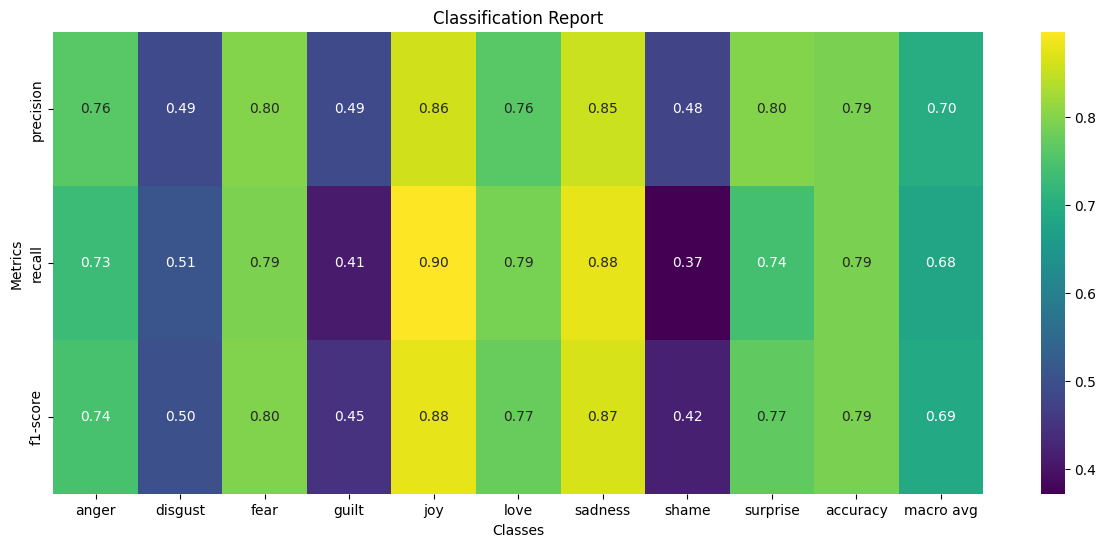

In [20]:
# Generate the classification report
report = classification_report(y_test, y_pred, output_dict=True, target_names=pipeline.classes_)
report['accuracy'] = accuracy_score(y_test, y_pred)
report['macro avg']['f1-score'] = f1_score(y_test, y_pred, average='macro')
report['weighted avg']['f1-score'] = f1_score(y_test, y_pred, average='weighted')

# Create a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()
# Plotting the classification report
plt.figure(figsize=(15, 6))
sns.heatmap(report_df.iloc[:-1, :].T.drop('support'), annot=True, fmt='.2f', cmap='viridis', cbar=True)
plt.title('Classification Report')
plt.xlabel('Classes')
plt.ylabel('Metrics')
plt.show()


Here we see that the model does somewhat well, and manages good scores for most classes, doing really well on sadness and joy specifically as we have more datapoints there. It does struggle with guilt, shame and disgust though, and even though we tried to mitigate the data scarcity for those classes, we couldn't do much better for those emotion classes.

In [21]:
# Saving the model
model_path = "./emotion_classifier.joblib"
joblib.dump(pipeline, model_path)

['./emotion_classifier.joblib']

In [22]:
nltk.download("punkt_tab")

# Function to use the trained model to predict the emotion of a given paragraph (not a single sentence)
# Model works with only sentences, so we need to split the paragraph into sentences and then predict the 
# emotion of each sentence. Then, we can find the average emotion of the paragraph, and the percentage of each emotion in the paragraph.
def predict_text_emotion(text: str, model_path: str) -> tuple:
    # Load the model
    model = joblib.load(model_path)

    # Split the text into sentences
    sentences = nltk.tokenize.sent_tokenize(text)

    # Predict the probabilities of each emotion for each sentence
    probabilities = [model.predict_proba([sentence]) for sentence in sentences]

    # Predict the most likely emotion for each sentence
    emotions = [model.predict([sentence]) for sentence in sentences]

    # Return the probabilities of the emotions over the entire text(average of the probabilities of each sentence) and the most likely emotion
    # Return it in json format: {"probabilities": {emotion: probability}, "top_emotion": emotion}
    # Calculate the average probabilities for each emotion
    avg_probabilities = {}
    for prob in probabilities:
        for emotion, value in zip(model.classes_, prob[0]):
            if emotion not in avg_probabilities:
                avg_probabilities[emotion] = 0
            avg_probabilities[emotion] += value / len(probabilities)

    # Determine the most likely emotion for the entire text
    top_emotion = max(avg_probabilities, key=avg_probabilities.get)

    # Return the result in the specified format
    return {
        "probabilities": avg_probabilities,
        "top_emotion": top_emotion
    }

# Test the function
paragraph = "The sun was shining brightly in the sky. The birds were chirping. The flowers were blooming. The children were playing in the park. The world seemed like an ok place."

print("Paragraph: ", paragraph)
pred = predict_text_emotion(paragraph, model_path)
print("Emotion Probabilities: ", pred["probabilities"])
print("Predicted Emotion: ", pred["top_emotion"])

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Xeth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Paragraph:  The sun was shining brightly in the sky. The birds were chirping. The flowers were blooming. The children were playing in the park. The world seemed like an ok place.
Emotion Probabilities:  {'anger': 0.1373111908648693, 'disgust': 0.11036468685866174, 'fear': 0.1475244312853729, 'guilt': 0.04884451725343383, 'joy': 0.3743952357055415, 'love': 0.04170080166018069, 'sadness': 0.07175452410898621, 'shame': 0.06078448900883674, 'surprise': 0.007320123254117085}
Predicted Emotion:  joy
